In [1]:
# 多个maxdegree时,怎么去选？
# Iteration 6,会返回所需要的点——寻找原则？找去除这个点后的子图度最大的点？
# 一路上来的话 是不是找连通度最小的那个点
# 入度为0的提前迭代？


In [2]:
import openpyxl
import copy
from openpyxl import Workbook
import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import time

In [3]:
starttime  = time.time()

In [4]:
def remove_node_and_calculate_degrees(OD, node_to_remove):
    # 转换为 numpy 数组，以方便操作
    OD = np.array(OD)

    # 删除目标节点对应的行和列
    OD_removed = np.delete(OD, node_to_remove, axis=0)  # 删除行
    OD_removed = np.delete(OD_removed, node_to_remove, axis=1)  # 删除列

    # 计算剩余节点的度
    out_degrees = np.sum(OD_removed, axis=1)  # 计算出度
    in_degrees = np.sum(OD_removed, axis=0)  # 计算入度

    return out_degrees, in_degrees, OD_removed


In [5]:
# 分个枝先
# if node_degree do not coop. to max_node_degree
# node.drop()
# 某个节点度明显小于 其他节点度  分支
def node_edge(id,MyOD): 
    node_want_go = [id]  # 目标节点列表，初始包含 max_degree
    total_node_cango = []  # 用于存储最终能到目标的所有节点
    node_rec = []
    node_cut = {}
    new_node_rec = {}
    returnitem = {}
    flag = 0  # 记录迭代次数
    try:

        while node_want_go:  # 继续搜索直到没有新节点能到达
            print(f"-GO_BACK--Iteration {flag + 1} --------------------------------------------")
            #print(node_want_go)
            used_node = []

            new_nodes = []  # 当前轮次找到的新节点
            for item in node_want_go:
                
                if MyOD and item < len(MyOD[0]):  # 确保 MyOD 非空且索引合法
                    
                    qnode = []
                    for i in range(len(MyOD)):
                        #print(f'node {item} status is {MyOD[i][item]} and {MyOD[i][item] == 1 and i not in total_node_cango}')
                        
                        
                        #if MyOD[i][item] == 1 and i not in total_node_cango:
                        if MyOD[i][item] == 1 and i not in total_node_cango:
                            used_node.append(item)
                            #print(f'node {item} status is {MyOD[i][item]} and {MyOD[i][item] == 1 and i not in total_node_cango}')
                            new_nodes.append(i)  # 发现能到达目标的节点
                            qnode.append(i)
                            #print(qnode)
                            total_node_cango.append(i)  # 避免重复添加
                    if qnode:        
                        new_node_rec[item]=qnode
                        print(f'node {item} -> {qnode}')
                    
                    
                
                else:
                    print("Error: max_degree exceeds column bounds or MyOD is empty.")
            
            if new_nodes != []:
                #print(used_node,node_want_go)
                unused_nodes = [node for node in node_want_go if node not in used_node]
                node_cut[item] = unused_nodes
            
                print(f'node {unused_nodes} dont go')
                node_rec.append(new_nodes)
            node_want_go = new_nodes  # 更新下一轮要探索的节点
            
            flag += 1
            print(f"new_nodes: {new_nodes}")


        print("Total nodes that can reach the target:", total_node_cango)

        for item in node_rec[-1]:
            # 计算去除这个点后的子图度
            out_degrees, in_degrees, OD_removed = remove_node_and_calculate_degrees(MyOD,item) 
            print(item,sum(out_degrees) )
            returnitem[item] = sum(out_degrees)
    except Exception as e:
        print(e)
        print(f'POSSIBLE NO POINT CAN GO TO THIS POINT {id}')
       
    return returnitem


In [6]:
with open('wanna_range.json','r') as f:
    wanna_range = json.load(f)

In [7]:
def get_values(filename,id = 0,delme = 0):
    wb = openpyxl.load_workbook(filename)
    sheet_names = wb.sheetnames
    print(sheet_names)

    sheet = wb[sheet_names[id]]
    maxrow = sheet.max_row 
    maxcol = sheet.max_column 
    value = sheet.cell(row=2, column=1).value
    alldata = []

    for row in sheet.iter_rows(min_row=1, max_row=maxrow, min_col=1, max_col=maxcol): # type: ignore
        row_data = [cell.value for cell in row]
        alldata.append(row_data)
    station_name = alldata[0][1:]

    if delme:
        del alldata[0]
        for i in range(len(alldata)):
            del alldata[i][0]


    return alldata,station_name

In [8]:
def refineme(data):
    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] is None:
                data[i][j] = 0
    return data

In [9]:
def convme(data,title):
    degree = {}
    alldegree = 0
    for i,row in enumerate(data):
        
        degree[title[i]] = sum(row)
        alldegree = alldegree + sum(row)
    return degree,alldegree

In [10]:
def findme_maxdegreee(degree):
    max_degree = max(degree.values())

    max_degree_node = []
    for key in degree:
        if int(degree[key]) == int(max_degree):
            max_degree_node.append(key)
    return(max_degree,max_degree_node)

In [11]:
def picme(station_name, MyOD):
    plt.figure(figsize=(12, 8))  # 增加画布尺寸
    MyOD = np.array(MyOD)
    plt.imshow(MyOD, cmap='Blues', aspect='auto', interpolation='nearest')
    plt.colorbar(label='Value')

    # 设置步长以减少标签密度
    step = max(1, len(station_name) //20)  # 只显示20个标签
    plt.xticks(ticks=np.arange(len(station_name))[::step], labels=station_name[::step], rotation=45, fontsize=8)
    plt.yticks(ticks=np.arange(len(station_name))[::step], labels=station_name[::step], fontsize=8)

    plt.title('Graph Adjacency')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.tight_layout()
    plt.show()


In [12]:
def dfs(matrix, start):
    vis_his = []  # 访问历史记录
    visited = []  # 已访问节点列表
    stack = [start]  # 用栈实现深度优先搜索
    vis_his.append(start)

    while stack:
        #print(stack)
        node = stack.pop()  # 弹出栈顶节点
        if node not in visited:
            visited.append(node)  # 标记为已访问
            # 将与当前节点相连的未访问节点压入栈中
            for i in range(len(matrix[node]) - 1, -1, -1):  # 从后往前遍历，确保顺序一致
                if matrix[node][i] == 1 and i not in visited:
                    stack.append(i)
                    vis_his.append(i)
    print(vis_his)
    vis_his = list(set(vis_his))
    return visited, vis_his

def bfs(matrix, start):
    visited = []  # 已访问节点列表
    queue = [start]  # 待访问节点队列
    vis_his = [start]  # 访问历史记录，按顺序记录

    while queue:
        node = queue.pop(0)  # 弹出队列头部节点
        if node not in visited:
            visited.append(node)  # 标记为已访问
            # 将与当前节点相连的未访问节点加入队列
            for i in range(len(matrix[node])):
                if matrix[node][i] == 1 and i not in visited and i not in queue:
                    queue.append(i)
                    vis_his.append(i)  # 按顺序记录访问历史

    return visited, vis_his


In [13]:
def replace_ones(matrix, i):
    # 替换第i行的1为0
    matrix[i] = [0 if x == 1 else x for x in matrix[i]]
    
    # 替换第i列的1为0
    for row in matrix:
        if row[i] == 1:
            row[i] = 0

In [14]:
MyOD,station_name = get_values(f'random_gen@{wanna_range}.xlsx',delme=1)

['Sheet1']


In [15]:
station_index = {}
index_station = {}
for i , item in enumerate(station_name):
    station_index[item] = i
    index_station[i] = item

In [16]:
MyOD = refineme(MyOD)
i = 0

In [17]:
def dropme(MyOD,allready_vis):
    for item in allready_vis:
        # 遍历每一行
        MyOD[station_index[item]] = [0 if x == 1 else x for x in MyOD[station_index[item]]]
        for row in MyOD:
            if row[station_index[item]] == 1:
                row[station_index[item]] = 0
    return MyOD

In [18]:
degree = convme(MyOD,station_name)

In [19]:
startpoint = []

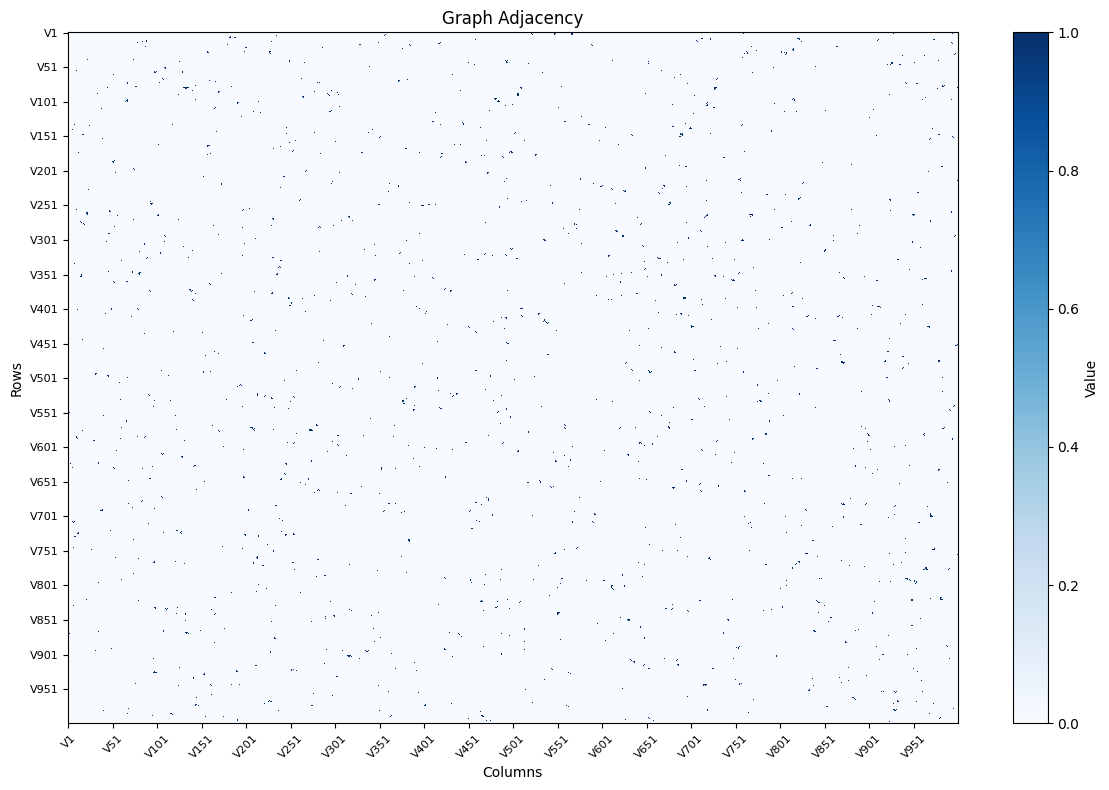

In [20]:
picme(station_name, MyOD)

In [21]:
'''max_degree = 499
total_node_cango = []

if MyOD and max_degree < len(MyOD[0]):  # 确保 MyOD 非空且 max_degree 不越界
    node_cango = []
    for i in range(len(MyOD)):
        if MyOD[i][max_degree] == 1:
            node_cango.append(i)
    
    total_node_cango.extend(node_cango)  # 如果需要将结果存储到 total_node_cango
else:
    print("Error: max_degree exceeds column bounds or MyOD is empty.")

# 打印结果
print("Nodes that can go:", node_cango)
'''

'max_degree = 499\ntotal_node_cango = []\n\nif MyOD and max_degree < len(MyOD[0]):  # 确保 MyOD 非空且 max_degree 不越界\n    node_cango = []\n    for i in range(len(MyOD)):\n        if MyOD[i][max_degree] == 1:\n            node_cango.append(i)\n    \n    total_node_cango.extend(node_cango)  # 如果需要将结果存储到 total_node_cango\nelse:\n    print("Error: max_degree exceeds column bounds or MyOD is empty.")\n\n# 打印结果\nprint("Nodes that can go:", node_cango)\n'

In [22]:
# # 分个枝先
# # if node_degree do not coop. to max_node_degree
# # node.drop()
# # 某个节点度明显小于 其他节点度  分支
# if True :  
#     node_want_go = [124]  # 目标节点列表，初始包含 max_degree
#     total_node_cango = []  # 用于存储最终能到目标的所有节点
#     node_rec = []
#     node_cut = {}
#     new_node_rec = {}
#     flag = 0  # 记录迭代次数

#     while node_want_go:  # 继续搜索直到没有新节点能到达
#         print(f"--- Iteration {flag + 1} --------------------------------------------")
#         #print(node_want_go)
#         used_node = []

#         new_nodes = []  # 当前轮次找到的新节点
#         for item in node_want_go:
            
#             if MyOD and item < len(MyOD[0]):  # 确保 MyOD 非空且索引合法
                
#                 qnode = []
#                 for i in range(len(MyOD)):
#                     #print(f'node {item} status is {MyOD[i][item]} and {MyOD[i][item] == 1 and i not in total_node_cango}')
                    
                    
#                     #if MyOD[i][item] == 1 and i not in total_node_cango:
#                     if MyOD[i][item] == 1 and i not in total_node_cango:
#                         used_node.append(item)
#                         #print(f'node {item} status is {MyOD[i][item]} and {MyOD[i][item] == 1 and i not in total_node_cango}')
#                         new_nodes.append(i)  # 发现能到达目标的节点
#                         qnode.append(i)
#                         #print(qnode)
#                         total_node_cango.append(i)  # 避免重复添加
#                 if qnode:        
#                     new_node_rec[item]=qnode
#                     print(f'node {item} -> {qnode}')
                
                
            
#             else:
#                 print("Error: max_degree exceeds column bounds or MyOD is empty.")
        
#         if new_nodes != []:
#             #print(used_node,node_want_go)
#             unused_nodes = [node for node in node_want_go if node not in used_node]
#             node_cut[item] = unused_nodes
        
#             print(f'node {unused_nodes} dont go')
#             node_rec.append(new_nodes)
#         node_want_go = new_nodes  # 更新下一轮要探索的节点
        
#         flag += 1
#         print(f"new_nodes: {new_nodes}")


#     print("Total nodes that can reach the target:", total_node_cango)

#     for item in node_rec[-1]:
#         # 计算去除这个点后的子图度
#         out_degrees, in_degrees, OD_removed = remove_node_and_calculate_degrees(MyOD,item) 
#         print(item,sum(out_degrees) )


In [23]:
station_index['V497']

496

In [24]:
i = 0  # 初始化i
visrec = []
startpoint = []  # 初始化起点列表
again_visit = copy.deepcopy(station_name)  # 未访问的所有节点列表

while True:
    print(f'Turn {i+1}')
 
    # 调用 convme 函数，获取度数和是否存在有效度数
    degree, alldegree = convme(MyOD, station_name)
    print(f'Total degree is {alldegree}')
    
    # 检查是否有有效的度数
    if alldegree:
        #picme(station_name, MyOD)
        max_degree, max_degree_node = findme_maxdegreee(degree)
        print(max_degree_node)
        
        # 获取最大度数的节点并添加到起点列表
        mychoice = np.random.randint(0,len(max_degree_node))
        #print(mychoice)
        startpoint.append(max_degree_node[mychoice])
        print(f'The max degree is {max_degree} @ {max_degree_node[mychoice]}')

        visrec.append(max_degree_node[mychoice])
        
        # 调用 bfs 函数，获取访问的节点（bfs_order 是节点的索引）
        bfs_order, allready_vis = bfs(MyOD, station_index[max_degree_node[mychoice]])
        
        # 更新已访问的节点列表，转换为节点名称
        allready_vis = [index_station[item] for item in bfs_order]
        print(f'The turn {i+1} visited node is {allready_vis}')
        
        # 从 MyOD 中删除已访问的节点
        MyOD = dropme(MyOD, allready_vis)
        
        # 调试：确保 MyOD 中已删除的节点
        #print(f'MyOD after drop: {MyOD}')
        
        # 更新仍未访问的节点列表，排除已访问的节点
        again_visit = [item for item in again_visit if item not in allready_vis]
        
        # 调试：输出仍未访问的节点
        print(f'Still node {again_visit} not visited')
        print(f'-----------------------------------------------------')
        
    else:
        # 当没有更多的度数时，合并已访问的节点
        print(f'-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+')
        startpoint = startpoint + again_visit
        # 按照数字部分排序
        sorted_startpoint = sorted(startpoint, key=lambda x: int(x[1:]))


        print(f'Total node {sorted_startpoint} is the origin. \n {len(sorted_startpoint)} nodes')
        print(f'+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-')
        break  # 结束循环
    
    i += 1  # 增加迭代次数


Turn 1
Total degree is 3177
['V81']
The max degree is 14 @ V81
The turn 1 visited node is ['V81', 'V45', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V509', 'V510', 'V727', 'V728', 'V729', 'V1000', 'V266', 'V451', 'V493', 'V494', 'V926', 'V927', 'V952', 'V410', 'V411', 'V558', 'V559', 'V444', 'V445', 'V446', 'V447', 'V694', 'V8', 'V118', 'V419', 'V585', 'V586', 'V758', 'V9', 'V757', 'V25', 'V587', 'V298', 'V150', 'V151', 'V194', 'V414', 'V415', 'V12', 'V163', 'V246', 'V254', 'V255', 'V256', 'V199', 'V200', 'V245', 'V215', 'V160', 'V56', 'V101', 'V102', 'V718', 'V719', 'V769', 'V770', 'V951', 'V495', 'V153', 'V654', 'V655', 'V759', 'V337', 'V994', 'V98', 'V190', 'V191', 'V955', 'V96', 'V97', 'V99', 'V100', 'V563', 'V515', 'V834', 'V113', 'V139', 'V197', 'V683', 'V689', 'V933', 'V942', 'V78', 'V198', 'V698', 'V833', 'V867', 'V498', 'V924', 'V950', 'V17', 'V878', 'V287', 'V288', 'V861', 'V862', 'V863', 'V355', 'V379', 'V452', 'V570', 'V182', 'V183', 'V188', 'V189', 'V703', 'V4

In [25]:
with open('start_nodes@ onedirection.json','w') as f:
    json.dump(sorted_startpoint,f)

In [26]:
USED_time = time.time()
print(f'total time is {USED_time- starttime}')

total time is 5.8909337520599365
